<h1>EDA</h1>

In [566]:
%pip install mplfinance
%pip install ta

from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import math
from ta.trend import ema_indicator, macd, macd_signal
from ta.momentum import rsi, stochrsi_k, stochrsi_d
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import on_balance_volume

"""
%pip install plotly
import plotly.graph_objects as go
"""
import random

TEST_NUM = 100 # set it to a small int so it avoids the overhead of loading the entire dataset


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
class Utilities:
    def __init__(self, is_test, test_num):
        self.is_test = is_test
        self.num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        self.test_num = test_num

    def get_all_files_in_dir(self, dir_name):
        fnames = [join(dir_name, f) for f in listdir(dir_name) if isfile(join(dir_name, f))]
        return fnames[:self.test_num if self.is_test else len(fnames)]
    
    def get_dataframes(self, dir_name):
        dfs = []
        for fname in self.get_all_files_in_dir(dir_name):
            try:
                df = pd.read_csv(fname)
                df['Date'] = pd.to_datetime(df['Date'])
                for nc in self.num_cols:
                    df[nc] = pd.to_numeric(df[nc])
                df.drop(columns='OpenInt', inplace=True)
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)
                dfs.append(df)
                df.name = fname.split('/')[-1].split('.')[0].upper()
            except Exception as e:
                pass # ignore invalid/empty files
                # print(e)
        return dfs

class BasicInfo:
    def __init__(self, dfs):
        self.dfs = dfs

    def top_n_most_traded(self, n):
        volume_stats = []

        for df in self.dfs:
            avg_volume = round(df['Volume'].mean())
            volume_stats.append({'ticker': df.name, 'avg_volume': avg_volume})

        volume_df = pd.DataFrame(volume_stats)
        top_n = volume_df.sort_values('avg_volume', ascending=False).head(n)
        return top_n
    
    def __get_random_stocks(self, n):
        rstock_inds = [random.randint(0, len(self.dfs) - 1) for _ in range(n)]
        return [self.dfs[ind] for ind in rstock_inds]
    
    def plot_random_assets(self, n, ndays):
        rows = math.ceil(n / 2)

        fig, axs = plt.subplots(rows, 2, figsize=(14, 4 * rows))
        axs = axs.flatten() 

        for i, df in enumerate(self.__get_random_stocks(n)):
            ax = axs[i]

            df_plot = df.copy().tail(ndays)
            df_plot = df_plot[['Open', 'High', 'Low', 'Close', 'Volume']]

            mpf.plot(df_plot,
                type='candle',
                volume=False,
                ax=ax,
                axtitle=df.name,
                show_nontrading=False)

        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()
    
    def plot_common_ta_indicators(self, n, ndays):
        for dfr in self.__get_random_stocks(n):
            df = dfr.tail(ndays).copy()
            df.name = dfr.name
            df['EMA20'] = ema_indicator(df['Close'], window=20)
            df['EMA50'] = ema_indicator(df['Close'], window=50)
            df['MACD'] = macd(df['Close'])
            df['RSI'] = rsi(df['Close'], window=14)
            df['BB_upper'] = bollinger_hband(df['Close'])
            df['BB_lower'] = bollinger_lband(df['Close'])
            df['MACD_signal'] = macd_signal(close=df['Close'])
            
            df = df.tail(len(df) - 50)

            apds = [
                mpf.make_addplot(df['EMA20'], color='blue'),
                mpf.make_addplot(df['EMA50'], color='purple'),
                mpf.make_addplot(df['BB_upper'], color='grey'),
                mpf.make_addplot(df['BB_lower'], color='grey'),

                mpf.make_addplot(df['MACD'], panel=1, color='green', ylabel='MACD'),
                mpf.make_addplot(df['MACD_signal'], panel=1, color='red'),

                mpf.make_addplot(df['RSI'], panel=2, color='orange', ylabel='RSI')
            ]

            mpf.plot(df,
                type='candle',
                volume=True,
                addplot=apds,
                panel_ratios=(4, 2, 2), 
                title=f'Candlestick with EMA, Bollinger, MACD, RSI ({df.name})',
                style='yahoo')
    
    def corr_mtx(self):
        returns_dict = {}

        for df in self.dfs:
            df.sort_values('Date', inplace=True)
            df['daily_return'] = df['Close'].pct_change()
            df.dropna(subset=['daily_return'], inplace=True)

            returns_dict[df.name] = df['daily_return']
        
        returns_df = pd.DataFrame(returns_dict)
        corr_matrix = returns_df.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True if len(self.dfs) <= 20 else False, fmt=".2f")
        plt.title("Stock Return Correlation Matrix")
        plt.tight_layout()
        plt.show()
    
    def kmeans(self):
        pass

utils = Utilities(is_test=True, test_num=TEST_NUM)
etf_dfs = utils.get_dataframes('data/ETFs')
stock_dfs = utils.get_dataframes('data/Stocks')                       
binfo_stock = BasicInfo(stock_dfs)
binfo_etf = BasicInfo(etf_dfs)

In [568]:
print("Number of stocks:", len(stock_dfs))
print("Number of ETFs:", len(etf_dfs))

Number of stocks: 100
Number of ETFs: 100


In [569]:
n = 5
print(f"Top {n} most traded stocks:")
most_traded_stocks = binfo_stock.top_n_most_traded(n)
most_traded_stocks

Top 5 most traded stocks:


ticker  avg_volume
35   FEYE     5250670
21   NYCB     4626226
92    PSX     3822872
62    BLL     1854412
58      L     1809152

In [570]:
print(f"Top {n} most traded ETFs:")
most_traded_etfs = binfo_etf.top_n_most_traded(n)
most_traded_etfs

Top 5 most traded ETFs:


ticker  avg_volume
20    IWM    55273401
91    FXI    19925113
71    VWO    12838577
25    DIA    10481567
5     JNK     6369455

Candlestick chart of a few random stocks:


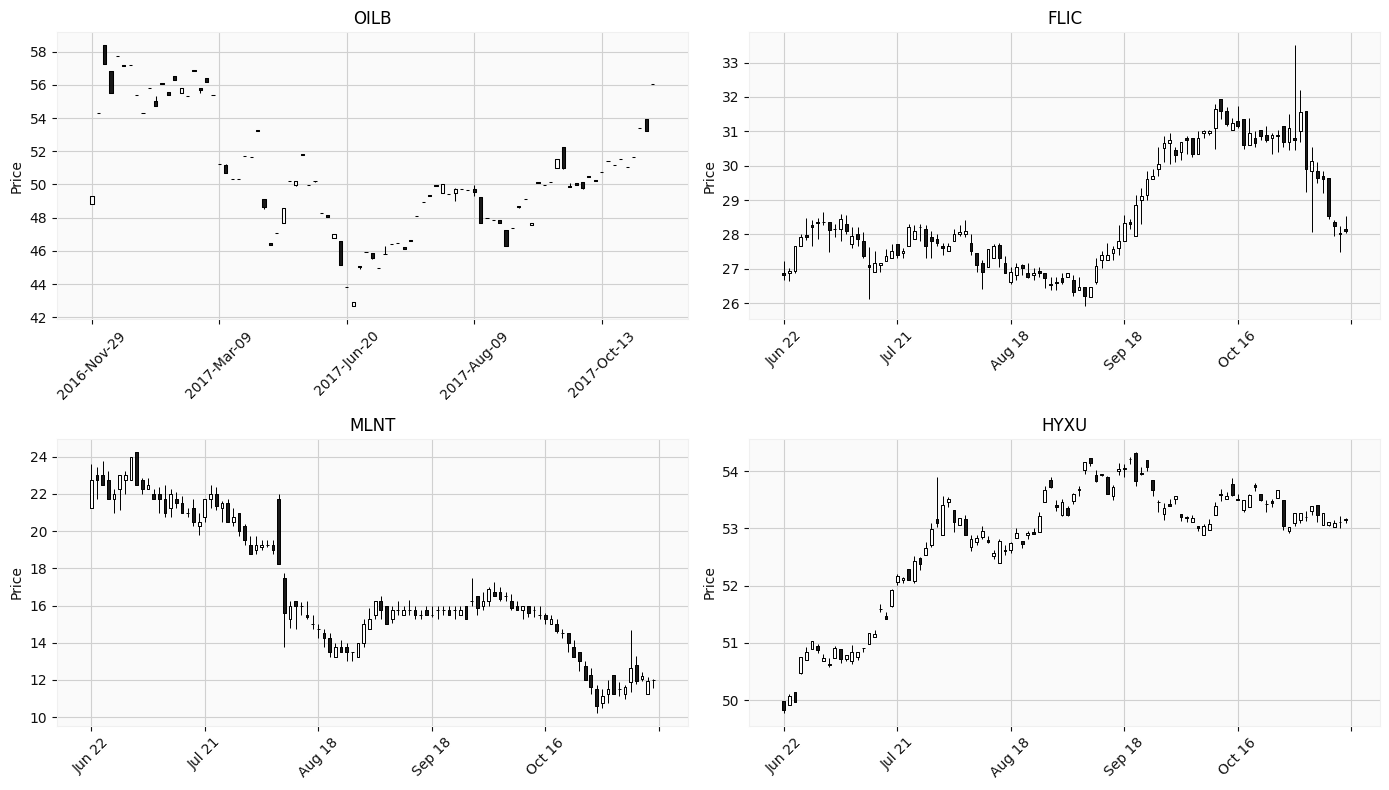

Candlestick chart of a few random ETFs:


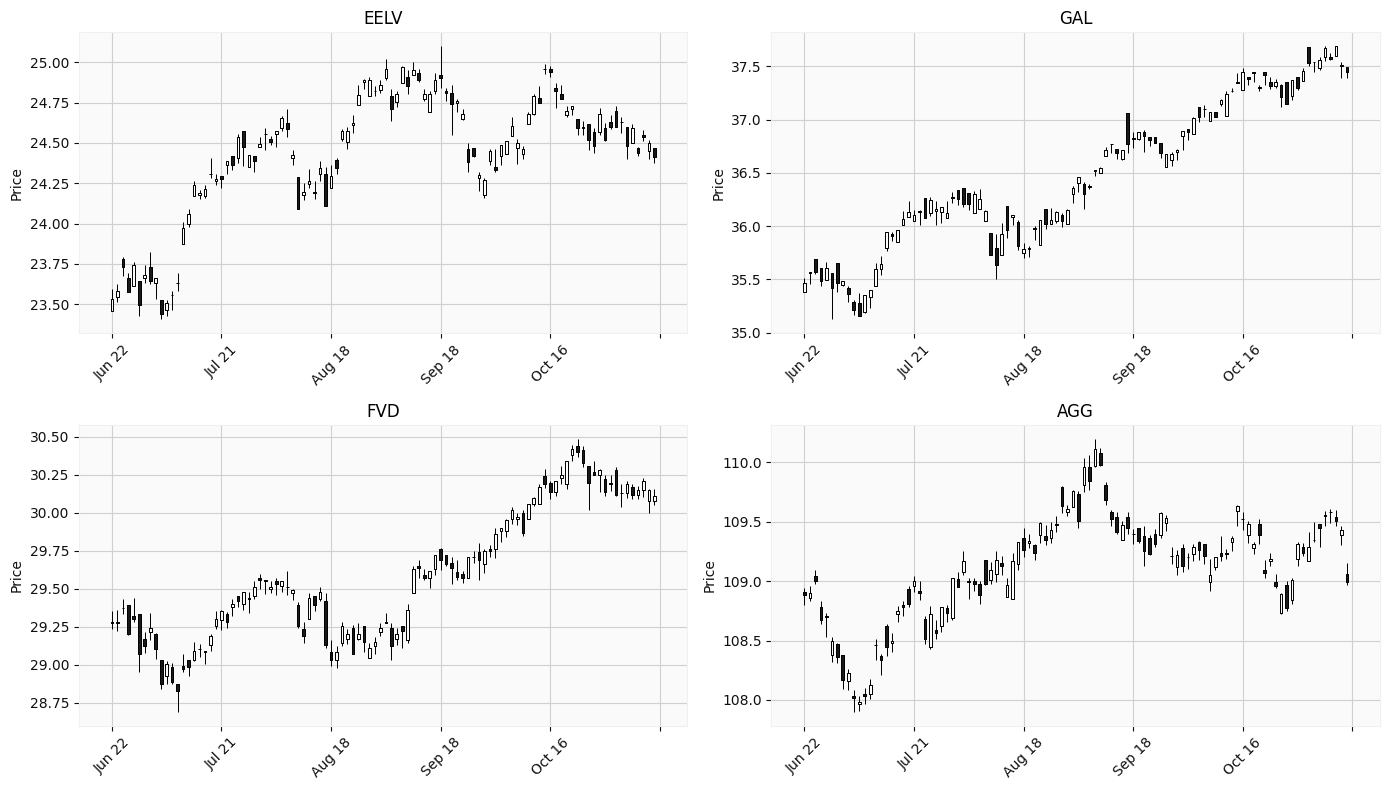

In [571]:
NRAND = 4
NDAYS = 100
print("Candlestick chart of a few random stocks:")
binfo_stock.plot_random_assets(NRAND, NDAYS)
print("Candlestick chart of a few random ETFs:")
binfo_etf.plot_random_assets(NRAND, NDAYS)

Plot of a few random stocks with EMA, Bollinger Bands, MACD and RSI


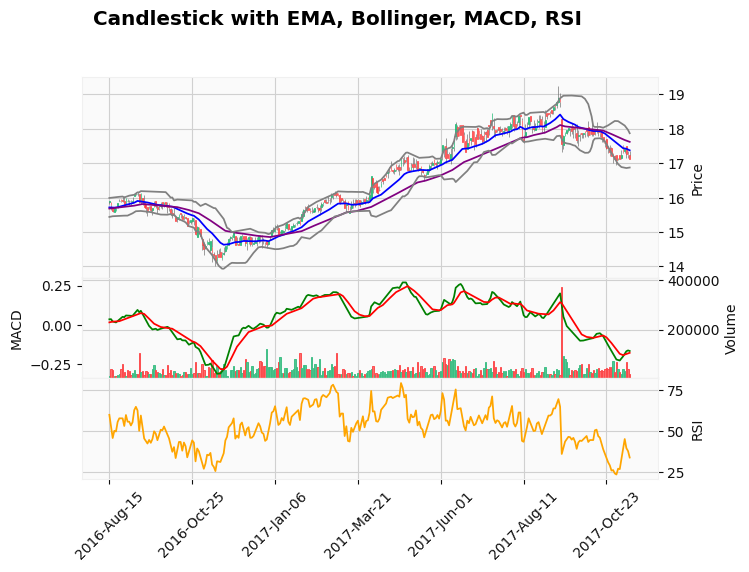

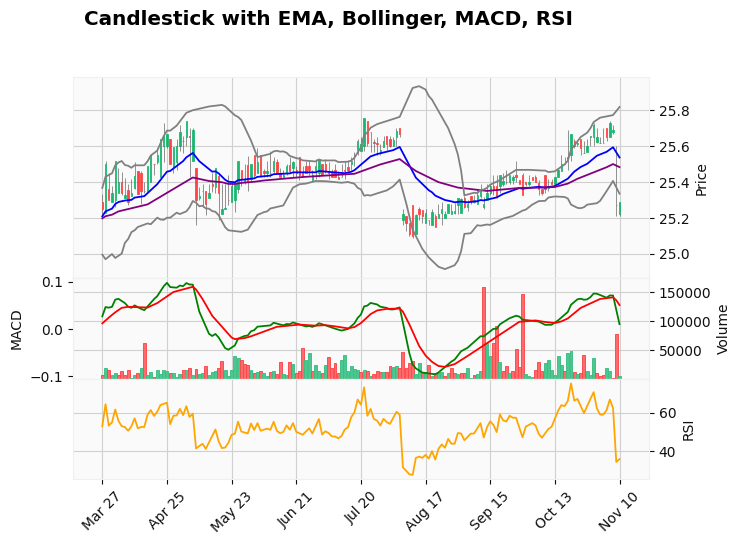

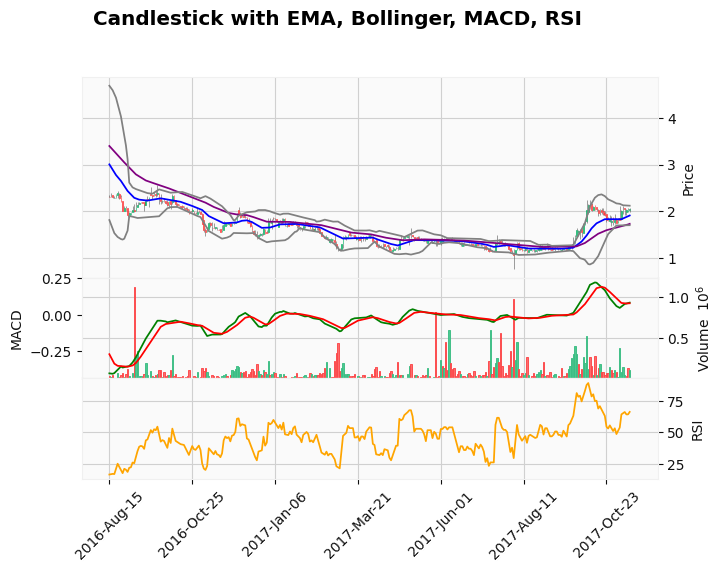

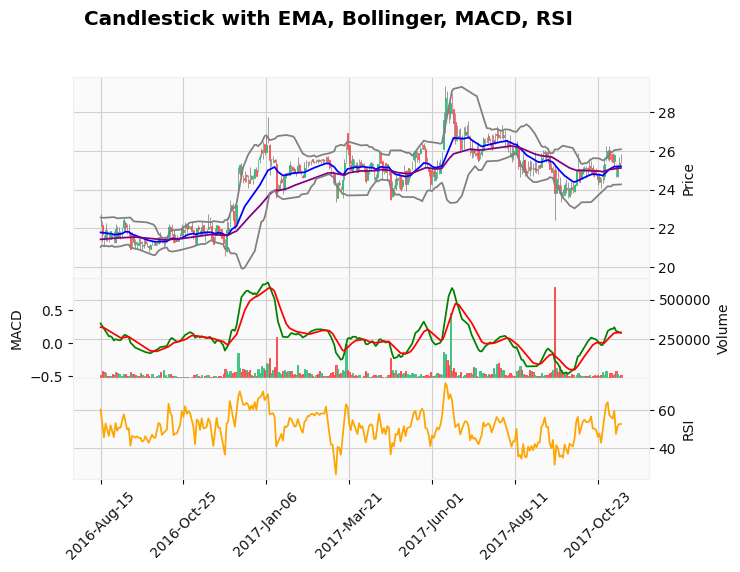

In [572]:
print("Plot of a few random stocks with EMA, Bollinger Bands, MACD and RSI")
YEAR = 365
binfo_stock.plot_common_ta_indicators(NRAND, YEAR)

Plot of a few random ETFs with EMA, Bollinger Bands, MACD and RSI


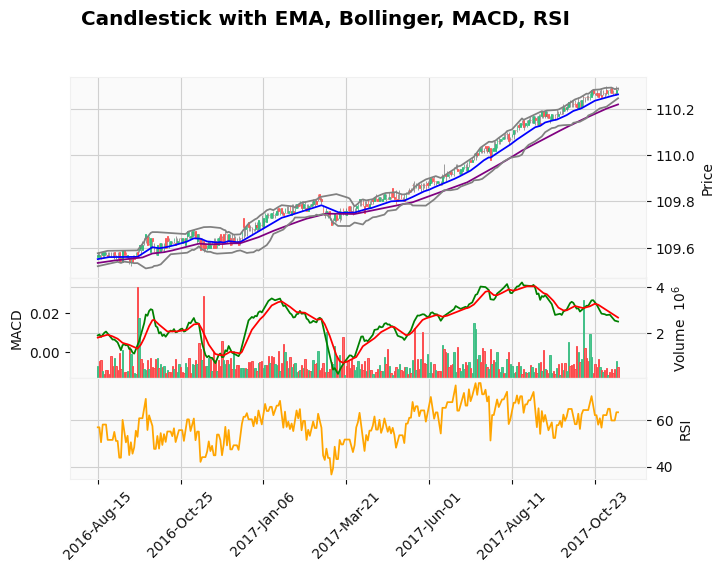

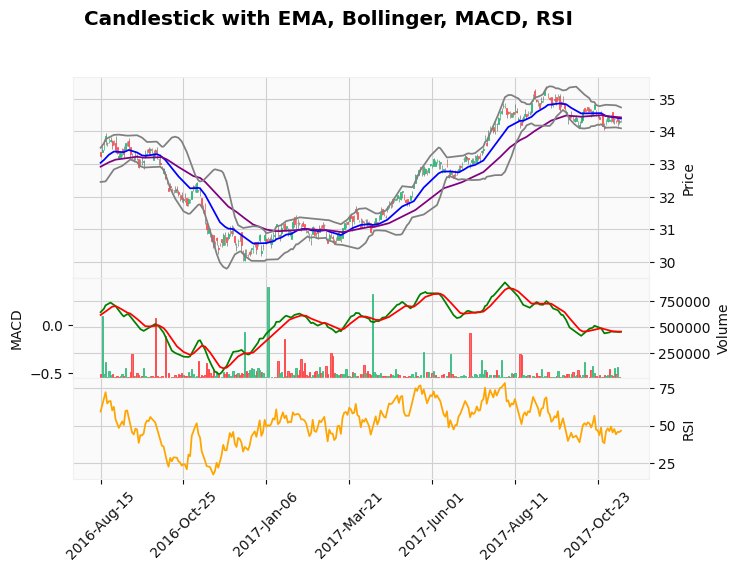

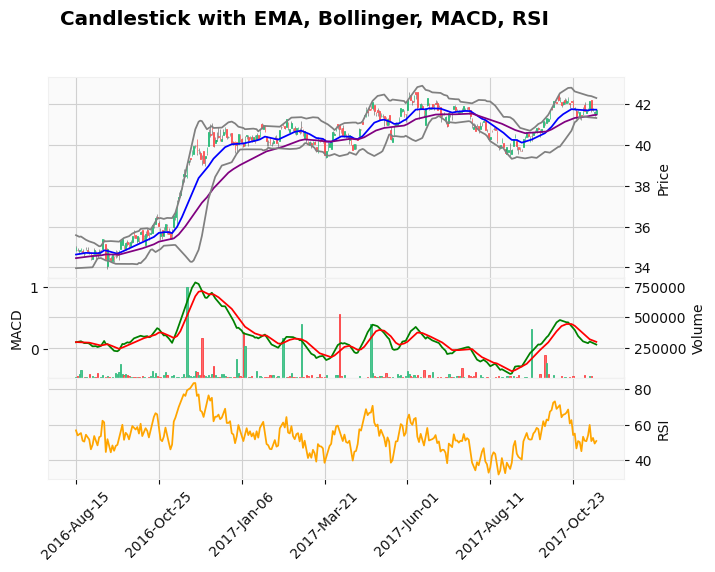

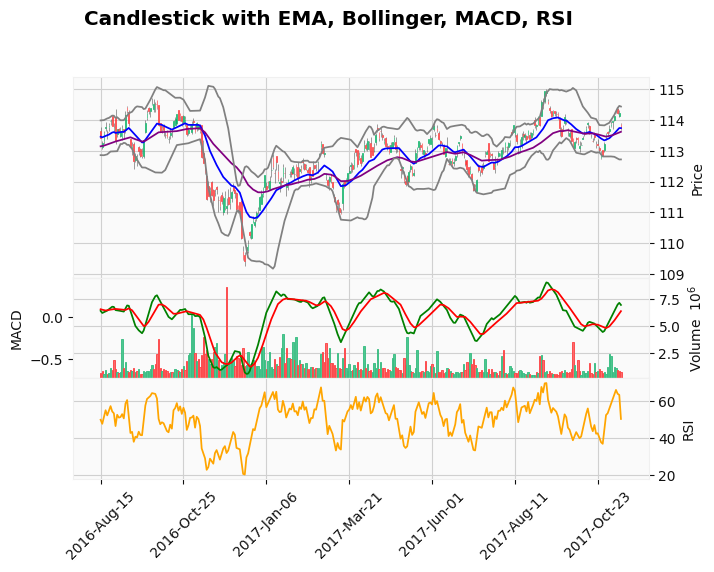

In [573]:
print("Plot of a few random ETFs with EMA, Bollinger Bands, MACD and RSI")
binfo_etf.plot_common_ta_indicators(NRAND, YEAR)

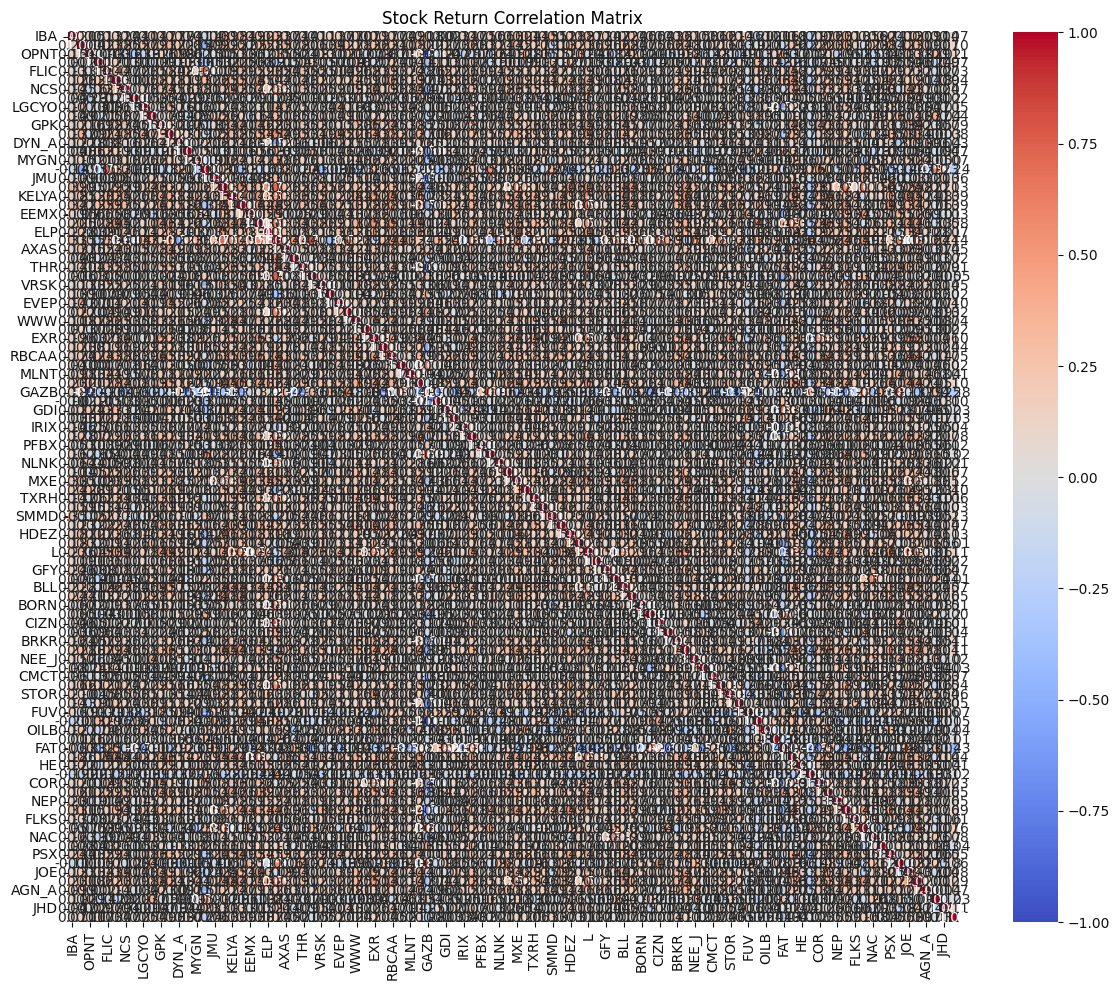

In [574]:
binfo_stock.corr_mtx()

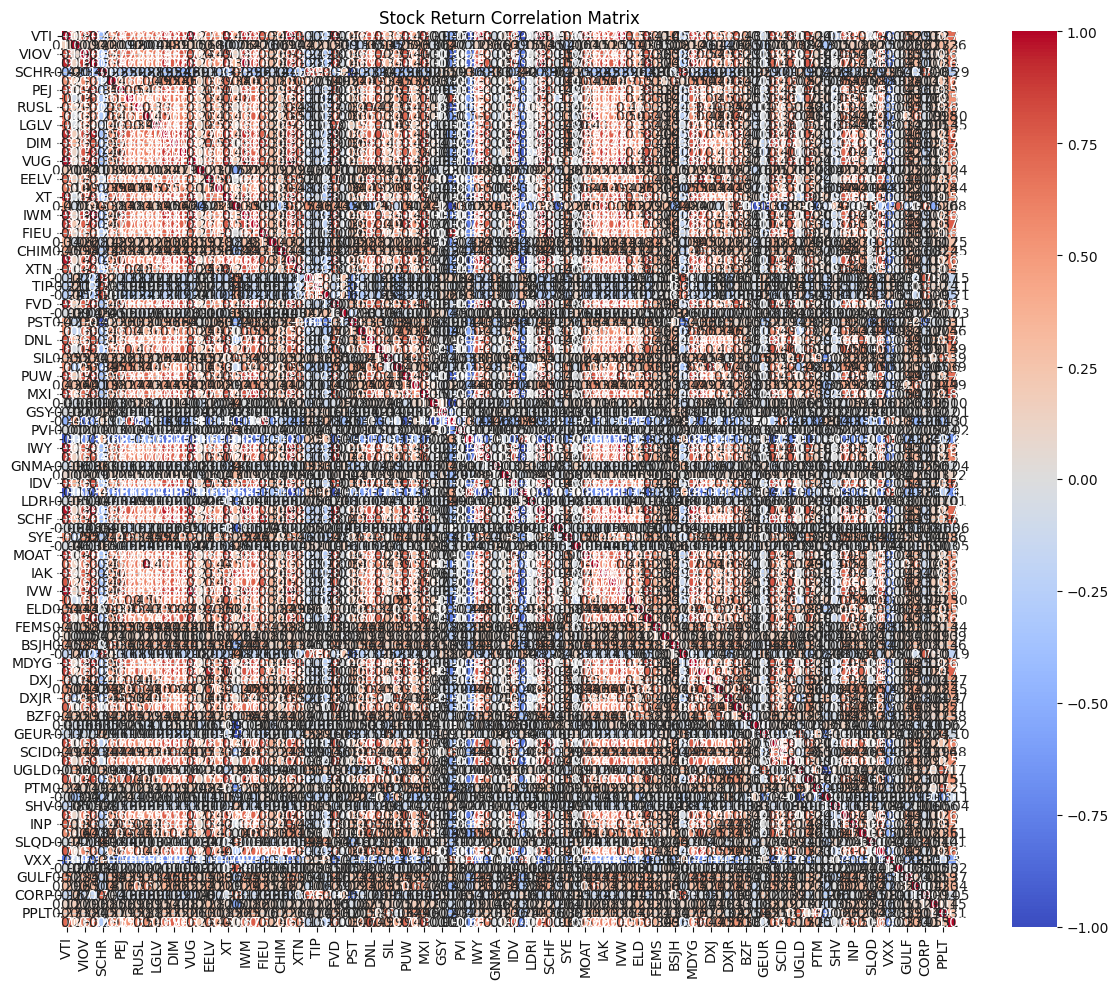

In [575]:
binfo_etf.corr_mtx()

<h1><EDA/h1>